# Preprocessing

This notebook contains the necessary steps to prepare and preprocess the data of the GLUCOSE dataset before using it to build a knowledge graph.

In [2]:
import pandas as pd
import json
import nltk
import spacy
#import neuralcoref
#import re
#from sentence_transformers import SentenceTransformer
import pickle
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

## 1.) GLUCOSE Dataset



### 1.1.) Data Reshaping

The data in GLUCOSE is given in a .csv table, each row conntaining an annotation.

In [3]:
GLUCOSE = '../data/GLUCOSE_training_data_final.csv'

data = pd.read_csv(GLUCOSE)

For illustration we print the first annotation and it's information:

In [4]:
for col in data.columns:
    print(col,':\n')
    print(data[col][0])
    print('-'*20)

experiment_id :

e56c7c3e-4660-40fb-80d0-052d566d676a__4
--------------------
story_id :

e56c7c3e-4660-40fb-80d0-052d566d676a
--------------------
worker_id :

19
--------------------
submission_time_normalized :

20190930
--------------------
worker_quality_rating :

3
--------------------
selected_sentence_index :

4
--------------------
story :

It was bedtime at our house. Two of the three kids hit the pillow and fall asleep. The third is a trouble maker. For two hours he continues to get out of bed and want to play. Finally he becomes tired and falls asleep.
--------------------
selected_sentence :

Finally he becomes tired and falls asleep.
--------------------
1_specificNL :

The third kid continues to  get out of bed and wants to play >Causes/Enables> The kid finally becomes tired and falls asleep
--------------------
1_specificStructured :

{The third kid}_[subject] {continues}_[verb] {to }_[preposition1] {get out of bed}_[object1] {and wants to play}_[object2] >Causes/Enable

In [5]:
ids = []
quals = []
for worker in data.worker_id:
    ids.append(worker)
for qual in data.worker_quality_rating:
    quals.append(qual)
ids = list(set(ids))
print('There are ',len(ids), 'different annotators')
print('with the following quality rankings: ',list(set(quals)))

There are  367 different annotators
with the following quality rankings:  [1, 2, 3]


In [6]:
print('There are ',len(data['experiment_id']),' annotations in GLUCOSE')

There are  65522  annotations in GLUCOSE


To simplify usage we group annotations in a way that we can accsess them per story.

Therefore we restructure the data as follows:
    
    stories = [{'story_id':'', 
                'story':'', 
                'resolved_story':''
                'annotations': [ {'quality':int, 
                                  'worker_id':int,
                                  'sentence':'',
                                  'sent_index':int, 
                                  'filled_in':int, 
                                  'dimensions': {1:[[style1_sent1, relation, style1_sent2], 
                                                    [style2_sent1, relation, style2_sent2],...],
                                                 2:[[],[],[],[]],
                                                 ...}},
                                 {...},...]},{...},...]
    

First we extract the story_ids in ascending order:

In [7]:
story_ids = sorted(list(set([id for id in data['story_id']])))
print(len(story_ids), ' stories in GLUCOSE_training_data_final')

4584  stories in GLUCOSE_training_data_final


And restructure the data next:

In [8]:
def get_stories(data):
    """
    orders data by story

    Parameters
    ----------
    data : class pandas.core.frame.DataFrame
        GLUCOSE training data.

    Returns
    -------
    stories: list
    """
    story_ids = sorted(list(set([id for id in data['story_id']])))
    stories = []
    j = 0
    for story_id in story_ids:
        story = {}
        story['story_id'] = story_id
        story['annotations'] = []
        for i, id in enumerate(data['story_id']):
            if story_id==id:
                story['story'] = data['story'][i]
                annotation = {}
                annotation['quality'] = int(data['worker_quality_rating'][i])
                annotation['worker_id'] = int(data['worker_id'][i])
                annotation['sentence'] = data['selected_sentence'][i]
                annotation['sent_index'] = int(data['selected_sentence_index'][i])
                annotation['filled_in'] = int(data['number_filled_in'][i])
                annotation['dimensions'] = get_dimensions(data, i)
                story['annotations'].append(annotation)      
        stories.append(story)
        if j%500==0:
            print(j, ' stories of ',len(story_ids),' processed')
        j+=1
    print(len(story_ids), ' stories of ',len(story_ids),' processed')
    return(stories)

def get_dimensions(data, i):
        """
        gets annotation per dimension

        Parameters
        ----------
        data : class pandas.core.frame.DataFrame
        GLUCOSE training data.
        i : int
            row index of dataframe.

        Returns
        -------
        dimensions: dict
            {1:[annotation_style_1,annotation_style_2,...],2:[],...}

        """
        
        dim_d = {'1_specificNL': 1, '1_specificStructured': 1, '1_generalNL': 1, '1_generalStructured': 1, 
                 '2_specificNL': 2, '2_specificStructured': 2, '2_generalNL': 2, '2_generalStructured': 2, 
                 '3_specificNL': 3, '3_specificStructured': 3, '3_generalNL': 3, '3_generalStructured': 3, 
                 '4_specificNL': 4, '4_specificStructured': 4, '4_generalNL': 4, '4_generalStructured': 4, 
                 '5_specificNL': 5, '5_specificStructured': 5, '5_generalNL': 5, '5_generalStructured': 5, 
                 '6_specificNL': 6, '6_specificStructured': 6, '6_generalNL': 6, '6_generalStructured': 6, 
                 '7_specificNL': 7, '7_specificStructured': 7, '7_generalNL': 7, '7_generalStructured': 7, 
                 '8_specificNL': 8, '8_specificStructured': 8, '8_generalNL': 8, '8_generalStructured': 8, 
                 '9_specificNL': 9, '9_specificStructured': 9, '9_generalNL': 9, '9_generalStructured': 9, 
                 '10_specificNL': 10, '10_specificStructured': 10, '10_generalNL': 10, '10_generalStructured': 10}
        
        dimensions = {}
        
        for dim in dim_d:
            if data[dim][i] == 'escaped':
                continue
            else:
                if dim_d[dim] in dimensions.keys():
                    dimensions[dim_d[dim]].append(edit_rule(data[dim][i]))
                else:
                    dimensions[dim_d[dim]] = [edit_rule(data[dim][i])]
        return(dimensions)
    
def edit_rule(rule):
    rule = rule.replace('   ',' ')
    rule = rule.replace('  ',' ')
    rule = rule.split('>')
    rule = [el.strip() for el in rule]
    return(rule)
    
stories = get_stories(data)

with open('../data/story_data.json','w') as f:
        json.dump(stories,f)
print('\n stored restructured data in "../data/story_data.json"')

0  stories of  4584  processed
500  stories of  4584  processed
1000  stories of  4584  processed
1500  stories of  4584  processed
2000  stories of  4584  processed
2500  stories of  4584  processed
3000  stories of  4584  processed
3500  stories of  4584  processed
4000  stories of  4584  processed
4500  stories of  4584  processed
4584  stories of  4584  processed

 stored restructured data in "../data/story_data.json"


### 1.2.) Coreference resolution

To better compare and match single sentences with their annotations we perform coreference resolution over every story with [NeuralCoref 4.0](https://github.com/huggingface/neuralcoref).

NeuralCoref is a pipeline extension for spaCy 2.1+ which annotates and resolves coreference clusters using a neural network.

To include this module we have to downgrade spaCy to version 2.1. If you don't want to do this, skip the next cell and load the data from disc in the following.

Due to enviroment conflict, this part of the code was rewritten in an extra file at './add_coref_to_story_dict.py'

This shall not be the finite solution.

In [7]:
import neuralcoref

nlp = spacy.load('en_core_web_sm')
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

for i, story in enumerate(stories):
    plain_story = story['story']
    doc = nlp(plain_story)
    resolved_story = doc._.coref_resolved
    stories[i]['resolved_story'] = resolved_story
    
    if i%500==0:
        print(i, ' stories of ',len(stories),' processed')
        
with open('./glucose_data/story_data.json','w') as f:
        json.dump(stories,f)
print('\n stored restructured data in "./glucose_data/story_data.json"')

0  stories of  4584  processed
500  stories of  4584  processed
1000  stories of  4584  processed
1500  stories of  4584  processed
2000  stories of  4584  processed
2500  stories of  4584  processed
3000  stories of  4584  processed
3500  stories of  4584  processed
4000  stories of  4584  processed
4500  stories of  4584  processed

 stored restructured data in "./glucose_data/story_data.json"


In [7]:
with open('./glucose_data/story_data_coref.json','r') as f:
        stories = json.load(f)
print('loaded restructured data from "./glucose_data/story_data_coref.json"\n')

print('Story Example:')
print(stories[0]['story'],'\n')
print('Coref Resolved Story:')
print(stories[0]['resolved_story'],'\n')

loaded restructured data from "./glucose_data/story_data_coref.json"

Story Example:
Tom always loved the ocean. He would vacation at the beach often. He decided to buy a vacation home. He got one right on the beach. Tom spent a lot of time there. 

Coref Resolved Story:
Tom always loved the ocean. Tom would vacation at the beach often. Tom decided to buy a vacation home. Tom got one right on the beach. Tom spent a lot of time there. 



### 1.3.) Data Analysis

To know what we are working with, let's have a look at the data. 

First we are interessted in the stories' length in sentences:

In [8]:
def get_story_sentence_span(stories):
    sentence_span = {}
    for story in stories:
        plain_story = nltk.sent_tokenize(story['story'])
        if len(plain_story) not in sentence_span:
            sentence_span[len(plain_story)] = 1
        else: 
            sentence_span[len(plain_story)] += 1
    return(sentence_span)

sentence_span = get_story_sentence_span(stories)

print(len(stories),' stories in total:\n')
for item in sorted(sentence_span.items()):
    print(item[1], '\tstories with\t', item[0], '\tsentences')
    

4584  stories in total:

9 	stories with	 1 	sentences
4 	stories with	 2 	sentences
6 	stories with	 3 	sentences
76 	stories with	 4 	sentences
4488 	stories with	 5 	sentences
1 	stories with	 6 	sentences


We see that the span of sentences per story alters between 1 and 6. Since this seems unreasonable and there is a huge difference in number of stories between sentence length 4 and 5 (and 5 and 6), let's have a look at the story with 6 and some stories with 4 sentences:

In [9]:
def print_story_with_sentence_span(stories):
    s_4 = []
    for story in stories:
        plain_story = nltk.sent_tokenize(story['story'])
        if len(plain_story) == 4:
            s_4.append(plain_story)
        if len(plain_story) == 6:
            print('story with 6 sentences:\n')
            print(plain_story,'\n\n')
    print('stories with 4 sentences:\n')
    for s in s_4[:5]:
        print(s,'\n')
    
print_story_with_sentence_span(stories)

story with 6 sentences:

['My friend Patrick came to visit me this past weekend.', 'I picked him up in Martinez and we drove back to Vallejo.', 'We visited the coast, went to a bar and had a lot of fun.', 'He went home on Sunday, and rode the Amtrak.', 'I had a lot of fun with him.', 's.'] 


stories with 4 sentences:

['4 Friends were playing secret santa.', 'Jason had to give Jen a gift.', 'He did not know what to give.', 'He ended up buying a nice notebook Jen pretended to like it.'] 

['Dad was worried about how he would pay the bills.', "Dad lost his job a month ago, and can't find new work.", "This is the first time the bills need to be paid since he lost his job Dad isn't sure how the bills are going to get paid.", 'Dad thinks the power might get shut off.'] 

['Steven was by a big flock of geese.', 'He went to go and chase them away.', 'They flew away at first.', 'They after started chasing him He was able to get away.'] 

['Joey went to the dentist.', 'He was scared and did no

Story with 6 sentences: The story with 6 sentences has a non sense sentence at the end.


Stories with 4 sentences: We see that all of the first five examples are missing a period. 

The stories consist of actually 5 sentences. This will give us a problem later for we want to accsess the stories' sentences via the index given in their annotations.

## 2.) Embeddings

To compute textual similarity and apply clustering algorithms, we embed every sentence in the GLUCOSE dataset with SentenceTransformers.

[SentenceTransformers](https://www.sbert.net/) is a Python framework for state-of-the-art sentence, text and image embeddings.


The initial work is described in the paper [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084)


### 2.1.) Sentence Extraction

First we need to extract all text from GLUCOSE that we want to embedd. These are:

- the whole stories
- each individual story sentence and each individual coref resolved story sentence
- each story sentence (and coref) split at ', ' and ' and '
- each sentences of the NL_specific and the NL_abstract rule

##### Example for split sentence:
Sentence: "When she handed me the drink, the lid came off and spilled on me"

Split: 
1. "When she handed me the drink"
2. "the lid came off"
3. "spilled on me"

##### Example for sentences of first rule:
Rule:  "Tom like(s) the ocean >Motivates> Tom vacations at  the beach often"

Sentences: 
1. "Tom likes the ocean"
2. "Tom vacations at the beach often"

We iterate over the GLUCOSE data and extract the relevant text. The text is stored in the list sentences.

In [6]:
def split_sentence(sentence):
    sentence_split = []
    if ', ' in sentence:
        sentence_split += sentence.split(', ')
    if ' and ' in sentence:
        sentence_split += sentence.split(' and ')
    if ' and ' in sentence and ', ' in sentence:
        sentence_split += re.split(', | and ', sentence)
    return(sentence_split)

sentences = []

for story in stories:
    
    # add whole story
    sentences.append(story['story'])
    
    # add story's sentences
    plain_story = nltk.sent_tokenize(story['story'])
    for sentence in plain_story:
        sentences.append(sentence)
        sentences += split_sentence(sentence)
        
    # add story's coref resolved sentences
    resolved_story = nltk.sent_tokenize(story['resolved_story'])
    for sentence in resolved_story:
        sentences.append(sentence)
        sentences += split_sentence(sentence)
        
    for annotation in story['annotations']:
        for dimension in annotation['dimensions']:
            rule = annotation['dimensions'][dimension][0]
            sentences.append(rule[0])
            sentences.append(rule[2])
            rule = annotation['dimensions'][dimension][2]
            sentences.append(rule[0])
            sentences.append(rule[2])

sentences = list(set(sentences))

print('Extracted ', len(sentences), ' sentences from GLUCOSE to embed')

Extracted  680522  sentences from GLUCOSE to embed


### 2.2.) Sentence Embeddings

For every sentence we now make an embedding and store both in pickle format.

The computation of the embeddings takes a while, therefore we recommend not to run the code again.

In [7]:
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

"""
run only if necessary:
"""
embeddings = model.encode(sentences, show_progress_bar=True)
with open('./glucose_data/embeddings.pkl', "wb") as f:
    pickle.dump({'sentences': sentences, 'embeddings': embeddings}, f, protocol=pickle.HIGHEST_PROTOCOL)

Instead load the embeddings from disc: 

(embedding file was too big to push to gitlab folder, if you want to rerun the code you'd have to compute embeddings and run the upper cell. Working on a solution...)

In [9]:
with open('../data/embeddings.pkl', "rb") as f:
    stored_data = pickle.load(f)
    embedding_map = dict(zip(stored_data['sentences'],stored_data['embeddings']))
print('Loaded ', len(embedding_map), ' embeddings')

Loaded  680522  embeddings


## 3.) Story Clustering

We cluster the stories with [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/index.html). The hdbscan library is a suite of tools to use unsupervised learning to find clusters, or dense regions, of a dataset. 

To simplify computation we reduce the dimensionality of the embeddings with [UMAP](https://umap-learn.readthedocs.io/en/latest/). Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. 

We followed the tutorial [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6).

To cluster the stories we first need their embeddings:

In [10]:
plain_stories = []
story_embeddings = []
for story in stories:
    plain_stories.append(story['story'])
    story_embeddings.append(embedding_map[story['story']])

### 3.1.) Clustering

In [12]:
STORY_CLUSTER_RESULTS = r'../story_cluster/clustering_results_min_'
cluster_size_min = 15
def cluster_data(embeddings, cluster_size_min=15):
       
    # Code from: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
    
    # reduce dimensionality of embeddings to reduce clustering time
    
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                                n_components=5, 
                                metric='cosine').fit_transform(embeddings)
    
    # cluster data
    
    cluster = hdbscan.HDBSCAN(min_cluster_size=cluster_size_min,
                              metric='euclidean',                      
                              cluster_selection_method='eom').fit(umap_embeddings)
    
    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    
    result.to_json(STORY_CLUSTER_RESULTS + str(cluster_size_min)+'.json')
    result.to_csv(STORY_CLUSTER_RESULTS + str(cluster_size_min)+'.csv')
    return(cluster, result)

cluster, result = cluster_data(story_embeddings, cluster_size_min=15)
print('divided data in ', max(result.labels), ' cluster')

divided data in  35  cluster


### 3.2.) Topic Modeling

To model the clusters' topics we use a class-based TF-IDF score.

In [13]:
def get_topic_words(plain_stories, cluster):
    
    docs_df = pd.DataFrame(plain_stories, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    def c_tf_idf(documents, m, ngram_range=(1, 1)):
        count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
        t = count.transform(documents).toarray()
        w = t.sum(axis=1)
        tf = np.divide(t.T, w)
        sum_t = t.sum(axis=0)
        idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
        tf_idf = np.multiply(tf, idf)
    
        return tf_idf, count
      
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(plain_stories))
    
    def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
        words = count.get_feature_names()
        labels = list(docs_per_topic.Topic)
        tf_idf_transposed = tf_idf.T
        indices = tf_idf_transposed.argsort()[:, -n:]
        top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
        return top_n_words
    
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    
    for cluster in top_n_words:
        print('Cluster ', cluster,':\n')
        print(top_n_words[cluster][0][0])
        print(top_n_words[cluster][1][0])
        print(top_n_words[cluster][2][0])
        print(top_n_words[cluster][3][0])
        print(top_n_words[cluster][4][0])
        print('-'*20)
    with open(STORY_CLUSTER_RESULTS+'15_top_words.json','w') as f:
        json.dump(top_n_words,f)
    return(top_n_words)

top_n_words = get_topic_words(plain_stories, cluster)

Cluster  -1 :

went
day
got
decided
friends
--------------------
Cluster  0 :

zoo
animals
monkey
lion
kids
--------------------
Cluster  1 :

dog
puppy
dogs
pet
ran
--------------------
Cluster  2 :

coffee
cup
drink
lid
spilled
--------------------
Cluster  3 :

dentist
shave
tooth
beard
teeth
--------------------
Cluster  4 :

snow
cold
outside
winter
ice
--------------------
Cluster  5 :

tree
wood
squirrel
build
yard
--------------------
Cluster  6 :

cat
kitten
cats
kittens
sarah
--------------------
Cluster  7 :

cd
song
music
headphones
listen
--------------------
Cluster  8 :

flu
medicine
better
doctor
feeling
--------------------
Cluster  9 :

sleep
asleep
night
fell
moon
--------------------
Cluster  10 :

bike
car
tire
driving
riding
--------------------
Cluster  11 :

clean
clothes
trash
laundry
wash
--------------------
Cluster  12 :

toy
birthday
wagon
party
billy
--------------------
Cluster  13 :

apple
banana
apples
tree
fruit
--------------------
Cluster  14 :

team

/home/nadia/Programs/anaconda3/envs/glucose/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


And then add the story cluster to story_data.json:

In [15]:
for i, story in enumerate(stories):
    cluster_id = int(result['labels'][i])
    story['cluster'] = cluster_id
    
with open('../data/story_data_final.json','w') as f:
        json.dump(stories,f)
print('added cluster information to "../data/story_data_final.json"')

added cluster information to "../data/story_data_final.json"


### 3.3.) Cluster Visualisation

In [18]:
import matplotlib.pyplot as plt

def mk_cluster_name_dict(top_n_words):
    
    cluster_names = {}
    
    for id in top_n_words:
        if int(id) == -1:
            continue
        name = ''
        name += top_n_words[id][0][0]
        name += ', '+top_n_words[id][1][0]
        name += ', '+top_n_words[id][2][0]
        id = int(id)
        cluster_names[id] = [name]
    return(cluster_names)

def add_coordinates_to_cluster_names(result, cluster_names):
    
    resultx = [el for el in result.x]
    resulty = [el for el in result.y]
    resultlabels = [el for el in result.labels]
    
    cluster_disribution = {}
    for i, cluster_id in enumerate(resultlabels):
        if cluster_id == -1:
            continue
        if cluster_id in cluster_disribution.keys():
            cluster_disribution[cluster_id]['x'] += resultx[i]
            cluster_disribution[cluster_id]['y'] += resulty[i]
            cluster_disribution[cluster_id]['count'] += 1
        else:
            cluster_disribution[cluster_id] = {}
            cluster_disribution[cluster_id]['x'] = resultx[i]
            cluster_disribution[cluster_id]['y'] = resulty[i]
            cluster_disribution[cluster_id]['count'] = 1
    
    for cluster_id in cluster_disribution:
        x = cluster_disribution[cluster_id]['x']/cluster_disribution[cluster_id]['count']
        y = cluster_disribution[cluster_id]['y']/cluster_disribution[cluster_id]['count']
        cluster_names[cluster_id].append(x)
        cluster_names[cluster_id].append(y)
    return(cluster_names)

def visualize_clusters(result, cluster_names):
    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD' , s=5.0, alpha=0.5)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=20.0,  alpha=0.5, cmap='hsv_r')
    plt.colorbar()
    for cluster_id in cluster_names:
        try:
            plt.text(cluster_names[cluster_id][1],cluster_names[cluster_id][2],cluster_names[cluster_id][0], fontsize=12)
        except:
            print('unplottable: ',cluster_id, cluster_names[cluster_id ])
    plt.title('Story Clusters of GLUCOSE Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('../story_cluster/story_cluster.png')
    plt.show()

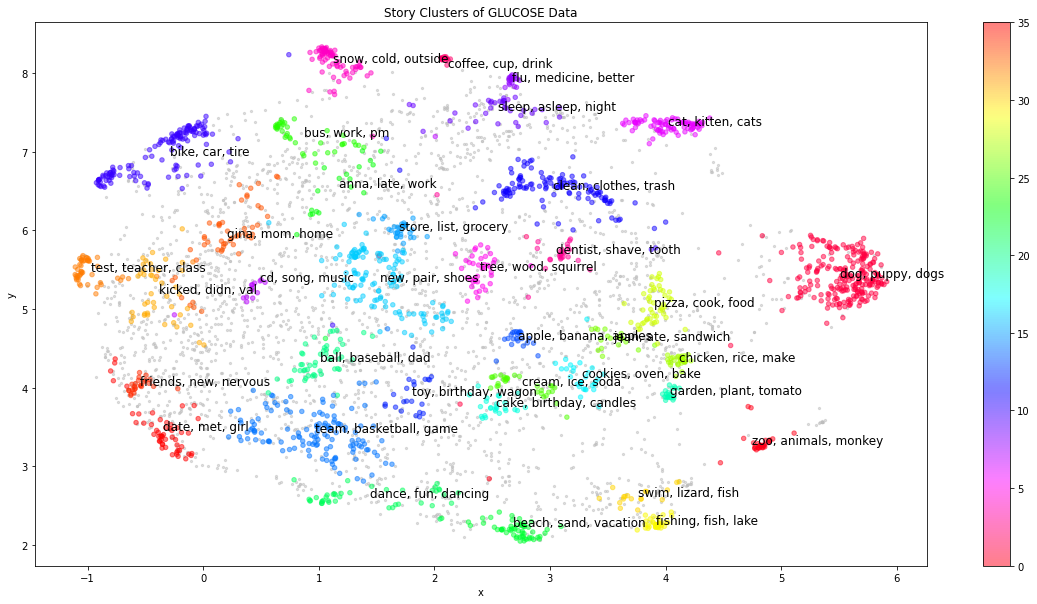

In [19]:
cluster_names = mk_cluster_name_dict(top_n_words)
cluster_names = add_coordinates_to_cluster_names(result, cluster_names)
visualize_clusters(result, cluster_names)

### 3.4.) Cluster Analysis

In [20]:
def get_cluster_distribution(result):
    
    count_dict = {}
    labels = [el for el in result.labels]
    for label in labels:
        if label in count_dict.keys():
            count_dict[label] += 1
        else:
            count_dict[label] = 1
    distribution = sorted(count_dict.items())
    for (label, count) in distribution:
        print(count, '\tstories in cluster\t', label)
    return(distribution)

cluster_distribution = get_cluster_distribution(result)

2721 	stories in cluster	 -1
34 	stories in cluster	 0
235 	stories in cluster	 1
22 	stories in cluster	 2
26 	stories in cluster	 3
75 	stories in cluster	 4
39 	stories in cluster	 5
84 	stories in cluster	 6
15 	stories in cluster	 7
21 	stories in cluster	 8
35 	stories in cluster	 9
140 	stories in cluster	 10
121 	stories in cluster	 11
22 	stories in cluster	 12
22 	stories in cluster	 13
133 	stories in cluster	 14
32 	stories in cluster	 15
122 	stories in cluster	 16
29 	stories in cluster	 17
26 	stories in cluster	 18
21 	stories in cluster	 19
50 	stories in cluster	 20
41 	stories in cluster	 21
59 	stories in cluster	 22
18 	stories in cluster	 23
39 	stories in cluster	 24
31 	stories in cluster	 25
18 	stories in cluster	 26
30 	stories in cluster	 27
48 	stories in cluster	 28
40 	stories in cluster	 29
18 	stories in cluster	 30
43 	stories in cluster	 31
47 	stories in cluster	 32
50 	stories in cluster	 33
24 	stories in cluster	 34
53 	stories in cluster	 35


We see that many stories are in cluster -1, the cluster of unassigned stories.

Also the clustering result differs from another each time running the code.

We need to put in some thoughts and effort here to come to a reasonable solution.